In [1]:
import torch
from fm3.fm3 import FM3
from fm3.tokenizer import FastChemTokenizerSelfies
from fm3.flow import get_path, get_source_distribution
from tqdm.notebook import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reload tokenizer
tokenizer = FastChemTokenizerSelfies.from_pretrained("./tokenizer_vocab/selftok_reordered")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Rebuild model
model = FM3(vocab_size=len(tokenizer), hidden=320, backbone_type="simple").to(device)
model.load_state_dict(torch.load("fm3_discrete.pt", map_location=device))
model.eval()

# Prepare path + source
path = get_path("polynomial", exponent=2.0)
source = get_source_distribution("mask", vocab_size=len(tokenizer))


✅ Special tokens bound: 0 1 2 3 4


🧪 Generating molecules via FM3 (continuous mode)...


✅ Sample 1: C1N=C1N1CCN2CC21
✅ Sample 2: CCCCC(C)OC=NCC=C(O)CC=CC=CCC=CC=C(O)CC=NC
✅ Sample 3: C=C=CC=CC=COCC(CCCNCCCOC)OC=NC
✅ Sample 4: CC=CNCCOC(=O)C(C)=CC=CC(C)=CC=CCNCCC(C)=CNN=CN
✅ Sample 5: NC=CC=C=CC=CCNC(=O)NNCC1=CC=C=N1
✅ Sample 6: C=CC=CCCCOC=NOC(O)CCC=CC(=O)NN=C


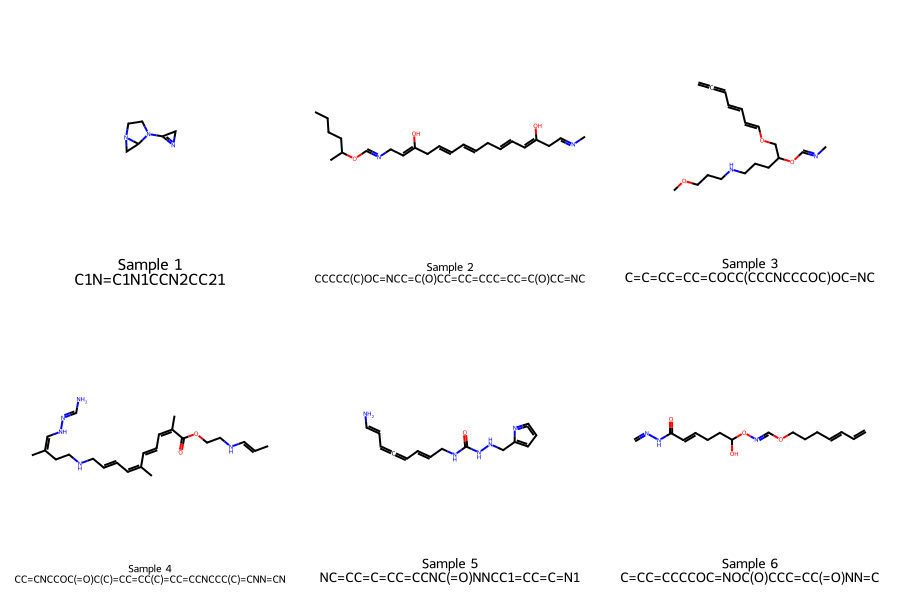


✓ Generated 6/6 valid molecules

Analyzing continuous trajectory stats...


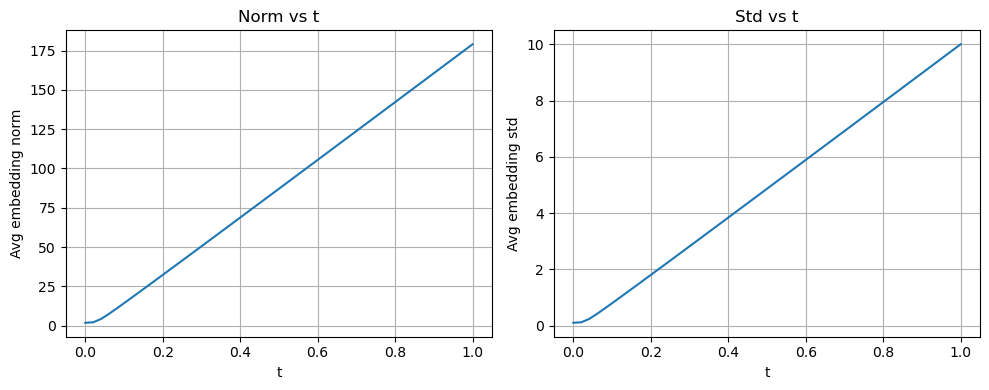

Initial norm: 1.7949, Final norm: 179.0415 (Δ 177.2466)


In [58]:
# ------------------- FM3 SAMPLING SCRIPT -------------------
import torch
from torchdiffeq import odeint
from rdkit import Chem
from rdkit.Chem import Draw
import selfies as sf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from tqdm.notebook import trange, tqdm

# ------------------- CONFIG -------------------
NUM_SAMPLES = 6
MAX_LEN = 12
STEPS = 200
MODE = "continuous"  # choose: "continuous" or "discrete"
TEMPERATURE = 0.35

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()
tokenizer = tokenizer  # assume already loaded
embedding_weight = model.get_input_embeddings().weight.detach().to(device)

# ------------------- HELPERS -------------------
def tokens_to_selfies(tok_list):
    """Convert token ids to clean SELFIES string"""
    clean = []
    for t in tok_list:
        if t == tokenizer.eos_token_id:
            break
        if t in (tokenizer.pad_token_id, tokenizer.bos_token_id):
            continue
        clean.append(int(t))
    if not clean:
        return ""
    try:
        return tokenizer.decode(clean, skip_special_tokens=True)
    except Exception:
        return " ".join(map(str, clean))

def decode_embeddings_to_tokens(x_final):
    """Nearest-neighbor decoding: embeddings → token IDs"""
    x_flat = x_final.view(-1, model.hidden)
    distances = torch.cdist(x_flat, embedding_weight)
    pred_tokens = torch.argmin(distances, dim=-1)
    return pred_tokens.view(x_final.shape[0], x_final.shape[1])

# ------------------- GENERATION -------------------
print(f"🧪 Generating molecules via FM3 ({MODE} mode)...")

if MODE == "continuous":
    # --- use built-in continuous generation ---
    tokens = model.generate(
        tokenizer=tokenizer,
        num_samples=NUM_SAMPLES,
        seq_len=MAX_LEN,
        steps=STEPS,
        mode="continuous",
    )

elif MODE == "discrete":
    # --- use built-in discrete flow sampling ---
    # we must define "path" and "source" placeholders (optional for your tokenizer)
    path = tokenizer  # not used internally, but passed for consistency
    source = tokenizer
    tokens = model.generate(
        tokenizer=tokenizer,
        path=path,
        source=source,
        num_samples=NUM_SAMPLES,
        seq_len=MAX_LEN,
        steps=STEPS,
        mode="discrete",
        temperature=TEMPERATURE,
    )
else:
    raise ValueError("MODE must be either 'continuous' or 'discrete'.")

# ------------------- POSTPROCESS -------------------
generated_SELFIES, generated_mols = [], []

for i in range(tokens.shape[0]):
    tok_list = tokens[i].cpu().numpy().tolist()
    pred_selfies = tokens_to_selfies(tok_list)
    pred_selfies_clean = pred_selfies.replace(" ", "").strip()

    if not pred_selfies_clean:
        print(f"Sample {i+1}: ❌ Empty SELFIES.")
        continue

    try:
        smi = sf.decoder(pred_selfies_clean)
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"Sample {i+1}: invalid SMILES '{smi}'")
            continue

        smi_canon = Chem.MolToSmiles(mol)
        generated_SELFIES.append(smi_canon)
        generated_mols.append(mol)
        print(f"✅ Sample {i+1}: {smi_canon}")

    except Exception as e:
        print(f"Sample {i+1}: Decoding error → {e}")

# ------------------- VISUALIZE -------------------
if generated_mols:
    legends = [f"Sample {i+1}\n{smi}" for i, smi in enumerate(generated_SELFIES)]
    img = Draw.MolsToGridImage(
        generated_mols,
        molsPerRow=min(3, len(generated_mols)),
        subImgSize=(300, 300),
        legends=legends,
        useSVG=False
    )
    display(img)
    print(f"\n✓ Generated {len(generated_SELFIES)}/{NUM_SAMPLES} valid molecules")
else:
    print("⚠ No valid molecules generated.")

# ------------------- OPTIONAL: ANALYZE TRAJECTORY -------------------
if MODE == "continuous":
    print("\nAnalyzing continuous trajectory stats...")
    try:
        with torch.no_grad():
            x0 = torch.randn(1, MAX_LEN, model.hidden, device=device) * 0.1
            t_dense = torch.linspace(0.0, 1.0, 50, device=device)
            traj = [x0]

            for t in t_dense[1:]:
                v = model(traj[-1], t.repeat(1))
                traj.append(traj[-1] + v * (t_dense[1] - t_dense[0]))

            # Detach before stacking
            traj = torch.stack([x.detach() for x in traj])

            norms = traj.norm(dim=-1).mean(dim=(1,2)).detach().cpu()
            stds = traj.std(dim=-1).mean(dim=(1,2)).detach().cpu()

            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plt.plot(t_dense.cpu().numpy(), norms.numpy())
            plt.xlabel('t'); plt.ylabel('Avg embedding norm'); plt.title('Norm vs t'); plt.grid(True)

            plt.subplot(1,2,2)
            plt.plot(t_dense.cpu().numpy(), stds.numpy())
            plt.xlabel('t'); plt.ylabel('Avg embedding std'); plt.title('Std vs t'); plt.grid(True)

            plt.tight_layout()
            plt.show()

            print(f"Initial norm: {norms[0]:.4f}, Final norm: {norms[-1]:.4f} (Δ {float(norms[-1]-norms[0]):.4f})")

    except Exception as e:
        print(f"Trajectory analysis failed: {e}")




Visualizing latent trajectory ( butterfly plot)...


C:\Users\mori\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129419 (\N{BUTTERFLY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


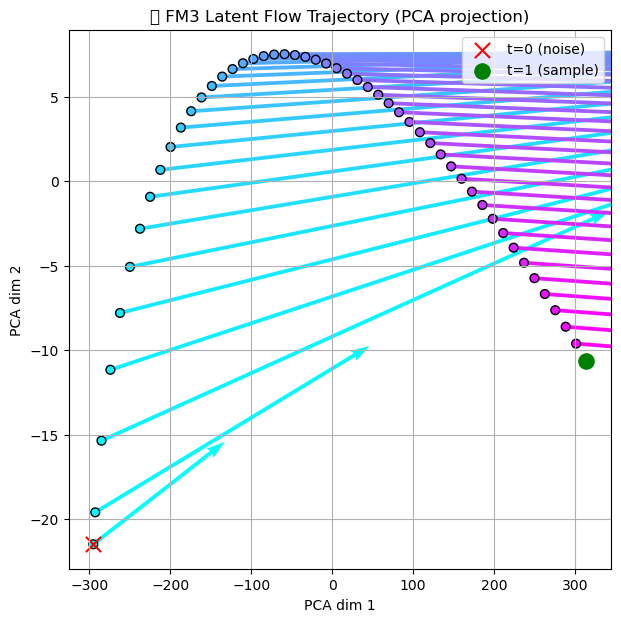

In [59]:
# ------------------- LATENT TRAJECTORY BUTTERFLY PLOT -------------------
if MODE == "continuous":
    print("\nVisualizing latent trajectory ( butterfly plot)...")
    try:
        with torch.no_grad():
            x0 = torch.randn(1, MAX_LEN, model.hidden, device=device) * 0.1
            t_dense = torch.linspace(0.0, 1.0, 50, device=device)
            traj = [x0]

            for t in t_dense[1:]:
                v = model(traj[-1], t.repeat(1))
                traj.append(traj[-1] + v * (t_dense[1] - t_dense[0]))

            traj = torch.stack([x.detach().cpu() for x in traj])  # (T, 1, L, D)
            X = traj.view(len(t_dense), -1)  # flatten sequence+hidden

            # PCA projection to 2D
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            X_2d = pca.fit_transform(X)

            # Compute local velocities
            V = np.gradient(X_2d, axis=0)

            # Plot trajectory arrows (flow over time)
            plt.figure(figsize=(7,7))
            plt.quiver(
                X_2d[:-1,0], X_2d[:-1,1],
                V[:-1,0], V[:-1,1],
                np.linspace(0,1,len(V)-1),
                cmap='cool',
                scale=10, width=0.007
            )
            plt.scatter(X_2d[:,0], X_2d[:,1],
                        c=np.linspace(0,1,len(X_2d)),
                        cmap='cool', s=40, edgecolor='k')

            plt.title("🦋 FM3 Latent Flow Trajectory (PCA projection)")
            plt.xlabel("PCA dim 1"); plt.ylabel("PCA dim 2")
            plt.grid(True)

            # Mark start and end
            plt.scatter(X_2d[0,0], X_2d[0,1], c='red', s=120, marker='x', label='t=0 (noise)')
            plt.scatter(X_2d[-1,0], X_2d[-1,1], c='green', s=120, marker='o', label='t=1 (sample)')
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"Flow visualization failed: {e}")


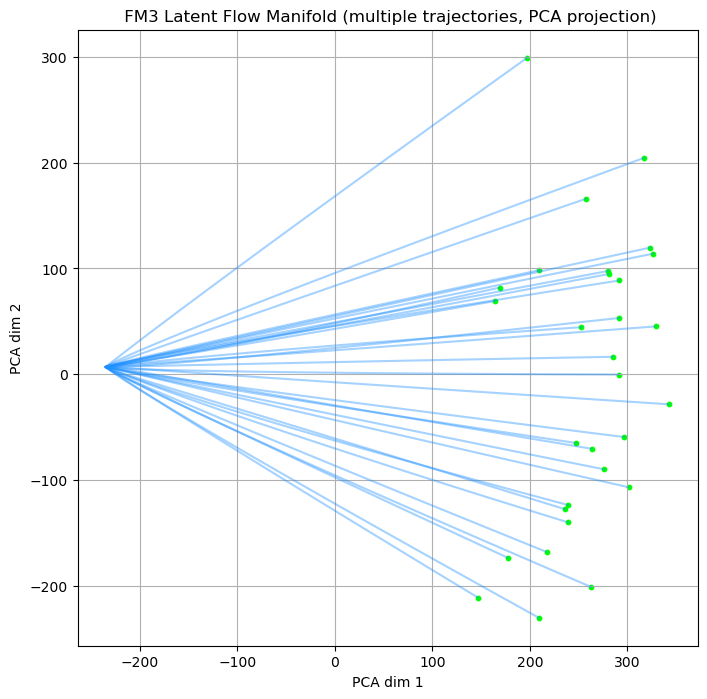

In [60]:
# MULTI-TRAJECTORY VERSION
n_trajectories = 30
t_dense = torch.linspace(0.0, 1.0, 40, device=device)
traj_all = []

with torch.no_grad():
    for _ in range(n_trajectories):
        x0 = torch.randn(1, MAX_LEN, model.hidden, device=device) * 0.1
        traj = [x0]
        for t in t_dense[1:]:
            v = model(traj[-1], t.repeat(1))
            traj.append(traj[-1] + v * (t_dense[1] - t_dense[0]))
        traj = torch.stack([x.cpu().detach() for x in traj])
        traj_all.append(traj.view(len(t_dense), -1))

# Flatten and project all trajectories with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_concat = torch.cat(traj_all, dim=0).numpy()
X_2d = pca.fit_transform(X_concat)

# Re-split trajectories for plotting
traj_2d = np.split(X_2d, n_trajectories)

plt.figure(figsize=(8,8))
for t in traj_2d:
    plt.plot(t[:,0], t[:,1], color='dodgerblue', alpha=0.4)
    plt.scatter(t[-1,0], t[-1,1], c='lime', s=10)
plt.title(" FM3 Latent Flow Manifold (multiple trajectories, PCA projection)")
plt.xlabel("PCA dim 1"); plt.ylabel("PCA dim 2")
plt.grid(True)
plt.show()


In [61]:
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_points = 10
t_dense = torch.linspace(0., 1., 20, device=device)

with torch.no_grad():
    x0 = torch.randn(n_points, MAX_LEN, model.hidden, device=device) * 0.2
    trajs = []
    for t in t_dense:
        v = model(x0, t.repeat(n_points))
        x0 = x0 + v * (t_dense[1] - t_dense[0])
        trajs.append(x0.detach().cpu())
    trajs = torch.stack(trajs)  # (T, N, L, D)


In [62]:
X_all = trajs.view(len(t_dense), n_points, -1)
pca = PCA(n_components=2)
X_2d = [pca.fit_transform(X_all[i]) for i in range(len(t_dense))]


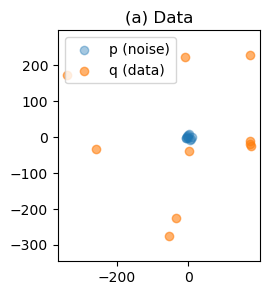

In [63]:
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.scatter(X_2d[0][:,0], X_2d[0][:,1], c='tab:blue', alpha=0.4, label='p (noise)')
plt.scatter(X_2d[-1][:,0], X_2d[-1][:,1], c='tab:orange', alpha=0.6, label='q (data)')
plt.legend(); plt.title('(a) Data'); plt.axis('equal'); plt.grid(False)


C:\Users\mori\AppData\Local\Temp\ipykernel_9848\3608338194.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[i][:,0], X_2d[i][:,1], alpha=0.3, c=plt.cm.cool(i / len(t_dense)))


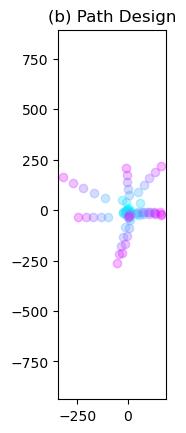

In [64]:
plt.subplot(1,4,2)
for i in range(0, len(t_dense), 3):
    plt.scatter(X_2d[i][:,0], X_2d[i][:,1], alpha=0.3, c=plt.cm.cool(i / len(t_dense)))
plt.title('(b) Path Design'); plt.axis('equal'); plt.grid(False)


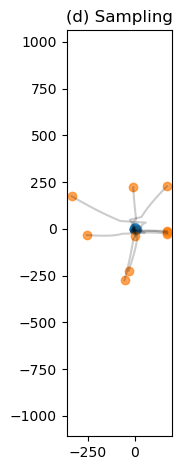

In [65]:
plt.subplot(1,4,4)
for j in range(n_points):
    traj = np.array([X_2d[i][j] for i in range(len(t_dense))])
    plt.plot(traj[:,0], traj[:,1], color='k', alpha=0.2)
plt.scatter(X_2d[0][:,0], X_2d[0][:,1], c='tab:blue', alpha=0.5)
plt.scatter(X_2d[-1][:,0], X_2d[-1][:,1], c='tab:orange', alpha=0.7)
plt.title('(d) Sampling'); plt.axis('equal'); plt.grid(False)

plt.tight_layout()
plt.show()


In [66]:
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- CONFIG ----------------
N_POINTS = 150
T_STEPS = 50
DT = 1.0 / T_STEPS
TRAIL_LENGTH = 6  # how many past frames to show per particle

# ---------------- TRAJECTORY GENERATION ----------------
with torch.no_grad():
    x = torch.randn(N_POINTS, MAX_LEN, model.hidden, device=device) * 0.2
    trajs = []
    for i in range(T_STEPS):
        t = torch.tensor(i / T_STEPS, device=device)
        v = model(x, t.repeat(N_POINTS))
        x = x + v * DT
        trajs.append(x.detach().cpu())
    trajs = torch.stack(trajs)  # (T, N, L, D)

# PCA projection
X_flat = trajs.view(T_STEPS, N_POINTS, -1)
pca = PCA(n_components=2)
X_2d = [pca.fit_transform(X_flat[i]) for i in range(T_STEPS)]

# Normalize scale
all_pts = np.concatenate(X_2d, axis=0)
center = all_pts.mean(axis=0)
spread = np.max(np.abs(all_pts - center)) * 1.2  # zoom-out factor

# ---------------- ANIMATION SETUP ----------------
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("FM3 Flow Matching: Sampling with Trails")
ax.set_xlabel("PCA dim 1")
ax.set_ylabel("PCA dim 2")
ax.set_xlim(center[0]-spread, center[0]+spread)
ax.set_ylim(center[1]-spread, center[1]+spread)
ax.set_aspect('equal')
ax.axis('off')

# Particle scatter and trails
points = ax.scatter(X_2d[0][:,0], X_2d[0][:,1],
                    c='royalblue', s=30, alpha=0.8, zorder=3)
trail_lines = [
    ax.plot([], [], color='deepskyblue', alpha=0.15, lw=1)[0]
    for _ in range(N_POINTS)
]
time_text = ax.text(0.02, 0.96, '', transform=ax.transAxes)

# ---------------- UPDATE FUNCTION ----------------
def update(frame):
    points.set_offsets(X_2d[frame])
    time_text.set_text(f"t = {frame / (T_STEPS-1):.2f}")

    # draw fading trails for each particle
    for j, line in enumerate(trail_lines):
        start = max(0, frame - TRAIL_LENGTH)
        seg = np.array([X_2d[k][j] for k in range(start, frame+1)])
        line.set_data(seg[:,0], seg[:,1])
        alpha = min(1.0, 0.1 + 0.9 * (len(seg)/TRAIL_LENGTH))
        line.set_alpha(alpha)
  # fade effect
    return [points, time_text, *trail_lines]

ani = FuncAnimation(fig, update, frames=T_STEPS, interval=100, blit=True)
plt.close()
HTML(ani.to_jshtml())
